### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [18]:
batch_size = 3 
learning_rate = 1e-12
target_size = 256
epochs = 1

In [19]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [20]:
total_batch = len(data_loader)
total_batch

3518

### 导入模型

In [21]:
model = VGG16()

In [22]:
model.load_state_dict(torch.load("./model/model_63_edge.pth"), strict=False)

<All keys matched successfully>

In [23]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}"
                      .format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.38228335976600647 Batch:100/3518 acc:0.9255031943321228 pre:0.9340123534202576 recall:0.87826007604599 F-measure:0.9182468056678772
Epoch:1 loss:0.37991243600845337 Batch:200/3518 acc:0.9243887066841125 pre:0.9237210154533386 recall:0.8902745842933655 F-measure:0.913224995136261
Epoch:1 loss:0.37997427582740784 Batch:300/3518 acc:0.9248178601264954 pre:0.9270938038825989 recall:0.892544686794281 F-measure:0.9166404604911804
Epoch:1 loss:0.4011688232421875 Batch:400/3518 acc:0.9252840876579285 pre:0.9302597641944885 recall:0.8934649229049683 F-measure:0.9192513227462769
Epoch:1 loss:0.39643073081970215 Batch:500/3518 acc:0.9250698685646057 pre:0.9294943809509277 recall:0.8948349356651306 F-measure:0.9189828634262085
Epoch:1 loss:0.39726996421813965 Batch:600/3518 acc:0.9246182441711426 pre:0.9294578433036804 recall:0.8933226466178894 F-measure:0.918437123298645
Epoch:1 loss:0.3896788954734802 Batch:700/3518 acc:0.9247403144836426 pre:0.9315345287322998 recall:0.8926133513

In [25]:
torch.save(model.state_dict(),"./model/model_64_edge.pth")

In [26]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [27]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [28]:
img = getInput("./image/1.jpg")

In [29]:
img.shape

torch.Size([3, 256, 256])

In [30]:
img = img.reshape(1, 3, 256, 256)
img = img.to(device)

In [31]:
predict = model(img)

In [32]:
predict.shape

torch.Size([1, 1, 256, 256])

In [33]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [34]:
msk.shape

torch.Size([256, 256, 1])

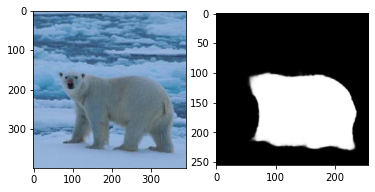

In [35]:
msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

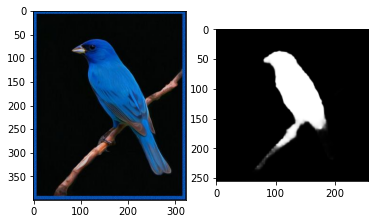

In [36]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

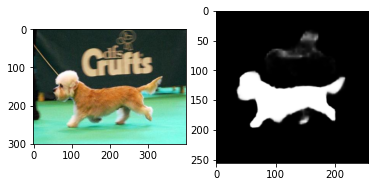

In [37]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

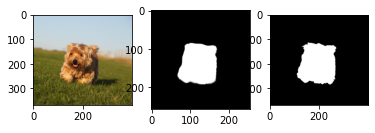

In [38]:
img = getInput("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk*255, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png"))
plt.show()